# Regualarization in MDP

In the following notebook we look at introducing regularization in MDPs.

In [1]:
""" Includes """
import jax
from jax import numpy as jnp
import jax.nn as nn
import matplotlib.pyplot as plt
from env.mdp import Sampler
from env.gridworld import Gridworld, gridplot
from algs.policy_gradients import PolicyGradientMethod, vanillaGradOracle, naturalGradOracle, monteCarloVanillaGrad, Sampler, monteCarloNaturalGrad, sample_batch
from itertools import accumulate

def flatten(v):
    return jnp.reshape(v,(list(accumulate(v.shape,lambda x,y:x*y))[-1],))

""" Initialize the Jax RNG """
key = jax.random.PRNGKey(0) 
from jax.config import config; config.update("jax_enable_x64", True)

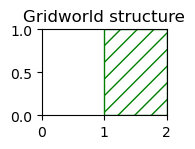

In [2]:
R = 100
goals = [((1,0),R)]
gridMDP = Gridworld(2,1,0.1,0.9,goals=goals,obstacles=[]) 
gridMDP.init_distrib =  jnp.exp(jax.random.uniform(key,(gridMDP.n,))) / \
    jnp.sum(jnp.exp(jax.random.uniform(key,(gridMDP.n,))))
    
fig, ax = plt.subplots(1,figsize=(2,1.6))
gridplot(gridMDP,ax,goals=goals)
ax.set_title('Gridworld structure')
fig.tight_layout()
plt.show()

We also choose to use a direct `softmax` policy parametrization, which we define here:

In [4]:
"""We define our policy parametrization"""
parametrization = lambda p : nn.softmax(p,axis=1)
"""As well as some random policy parameter vector"""
theta = jax.random.uniform(key,(gridMDP.n,gridMDP.m)) # where the dimensionality matches the MDP

The regularizer affects the computation of the objective function $J$.

In [3]:
def J(mdp,pi, regularizer = None): 
    unreg_J = jnp.dot(flatten(mdp.R),flatten(mdp.occ_measure(pi)))
    if regularizer is None: return unreg_J
    else:
        return unreg_J 

In [21]:
beta  = 0.2

_pi = parametrization(theta)
unreg_J = jnp.dot(flatten(gridMDP.R),flatten(gridMDP.occ_measure(_pi)))

shannonEntropy = lambda p : -jnp.dot(jnp.log(p),p)
reg = lambda p : beta * shannonEntropy(p)

om = gridMDP.state_occ_measure(_pi)
reg_term = jnp.dot(jax.vmap(reg)(_pi),om)

J = unreg_J - reg_term
J

DeviceArray(5.5385238, dtype=float64)